In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date, timedelta

import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import proplot as pplt
import spotpy
#warning
import warnings
warnings.filterwarnings('ignore')

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

In [2]:
#############################################################
# Xanthos grid info
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')
#GRDC list
GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')
#GRDC data
grdc_basin_m3persec  =  pd.read_csv(dir_in + '/grdc_91basin_m3persec_1971_1990_monthly.csv')
##
nbasins = GRDC_xanthosCoordIndx.shape[0]
basins91 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_91 = [basinName['Basin_Name'][basins91[ii] - 1] for ii in range(nbasins)]

## flow data
grdc_m3persec = np.zeros([nbasins, 240])
for ii in range(nbasins):   
    basin_num = basins91[ii]
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])

### KGE : Calibration & Validation

In [3]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

In [4]:
file_dir_watch_vald = dir_in + '/Simulated/SimulatedFinal-HP/flow/'
file_dir_watch_natr = dir_in + '/Simulated/SimulatedFinal-YL/flow/'

SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
manual_selection = [0,7,4, 2,8,12]
kge_calval_regulated = np.zeros([91,3])
kge_calval_regulated[:,0] = basins91
kge_calval_natural = kge_calval_regulated.copy()
for jj in range(len(basins91)):
    basin_num = basins91[jj].astype(np.int32)    
    ## observed
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
    qobs_calibration= grdc_m3persec[0:120]
    qobs_validation = grdc_m3persec[120:240]    
    qobs_validation_ts = timeseries_coverter(qobs_validation, start_yr=1981, ending_yr=1990)

    ## simulated
    data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration= data_basin[0:120]
    qsim_validation = data_basin[120:240]
    qsim_validation_ts = timeseries_coverter(qsim_validation, start_yr=1981, ending_yr=1990)

    ## Natural
    data_basin_yl = np.load(file_dir_watch_natr + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration_yl= data_basin_yl[0:120]
    qsim_validation_yl = data_basin_yl[120:240]
    qsim_validation_tsyl = timeseries_coverter(qsim_validation_yl, start_yr=1981, ending_yr=1990)
    

    # KGE : regulated
    kge_calr = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 
    kge_valr = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation) 
    kge_calval_regulated[jj,1] = kge_calr
    kge_calval_regulated[jj,2] = kge_valr
    # KGE : natural
    kge_caln = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration_yl) 
    kge_valn = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation_yl) 
    kge_calval_natural[jj,1] = kge_caln
    kge_calval_natural[jj,2] = kge_valn


kge_calval_regulated_dfx = pd.DataFrame(kge_calval_regulated)
kge_calval_regulated_dfx.columns = ['Basin','KGE-Calibration','KGE-Validation']  

kge_calval_natural_dfx = pd.DataFrame(kge_calval_natural)
kge_calval_natural_dfx.columns = ['Basin','KGE-Calibration','KGE-Validation']  


### Plotting

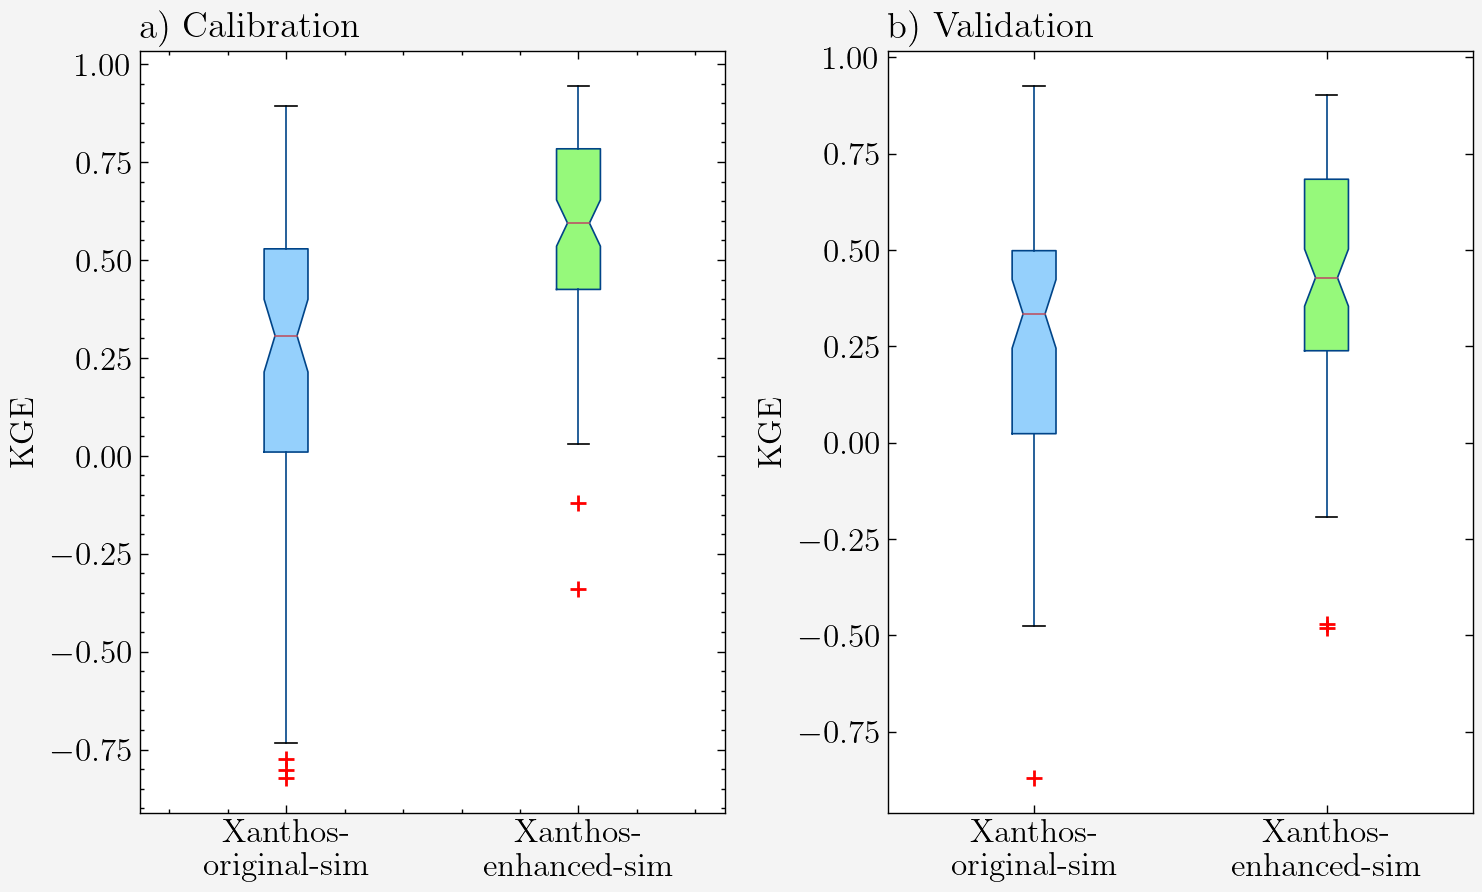

In [5]:
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 

SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,}

plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    #calib
    kge_calibration = pd.DataFrame()
    kge_calibration[['Basin','KGEnat']] = kge_calval_natural_dfx[['Basin',	'KGE-Calibration']]
    kge_calibration['KGEreg'] = kge_calval_regulated_dfx['KGE-Calibration']
    # valid
    kge_validation = pd.DataFrame()
    kge_validation[['Basin','KGEnat']] = kge_calval_natural_dfx[['Basin',	'KGE-Validation']]
    kge_validation['KGEreg'] = kge_calval_regulated_dfx['KGE-Validation']


    ###
    SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
    fig, axs = pplt.subplots(nrows=1, ncols=2, refheight='2.75in', share=0, journal='agu2')
    kge_calibration[kge_calibration < - 1] = np.nan
    ax =axs[0]
    kge_calibration[['KGEnat','KGEreg']].boxplot(ax=ax, notch=True, fillcolor=['light blue', 'light green'],edgecolor='r', sym='+')
    #ax.set_ylim([-0.41,1])
    ax.format(ylabel='KGE', title='Calibration', abcstyle='a)', titleloc='l', grid=False)
    #ax.set_xticklabels(['Distributed- \n Natural','Distributed- \n Regulated'])
    ax.set_xticklabels(['Xanthos- \n original-sim','Xanthos- \n enhanced-sim'])

    kge_validation[kge_validation < - 1] = np.nan
    ax =axs[1]
    kge_validation[['KGEnat','KGEreg']].boxplot(ax=ax, notch=True, fillcolor=['light blue', 'light green'],edgecolor='r', sym='+')
    #ax.set_ylim([-0.41,1])
    ax.format(ylabel='KGE', title='Validation', abcstyle='a)', titleloc='l', grid=False)
    #ax.set_xticklabels(['Distributed- \n Natural','Distributed- \n Regulated'])
    ax.set_xticklabels(['Xanthos- \n original-sim','Xanthos- \n enhanced-sim'])
    ax.minorticks_off()

plt.tight_layout()   

#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig(dir_out + "Figure-8.png", **SAVE_KWDS)   